# Segmentation of Indian Traffic

In [ ]:
#Run only if necessary (Incase of DLL error)
# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66

libcudnn8:
  Installed: 8.4.1.50-1+cuda11.6
  Candidate: 8.9.0.131-1+cuda12.1
  Version table:
     8.9.0.131-1+cuda12.1 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.9.0.131-1+cuda11.8 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.8.1.3-1+cuda12.0 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.8.1.3-1+cuda11.8 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.8.0.121-1+cuda12.0 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.8.0.121-1+cuda11.8 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.7.0.84-1+cuda11.8 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.6.0.163-1+cuda

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (74.6 MB/s)
(Reading database ... 122349 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 122316 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.7

#Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
import tarfile

file = tarfile.open('/path/to/final_thesis_dataset/idd-lite.tar.gz')

file.extractall('/content/dataset')

file.close()

In [1]:
def return_file_names_df(root_dir):
    """Function to return an array consisting of path of each of the original image and labels for both train and evaluation dataset"""
    data_root_path=root_dir
    images_doc='leftImg8bit'
    mask_doc='gtFine'
    image_path=os.path.join(data_root_path,images_doc)
    train_image_path_scenes=os.listdir(os.path.join(image_path,'train'))
    val_image_path_scenes=os.listdir(os.path.join(image_path,'val'))
    mask_path=os.path.join(data_root_path,mask_doc)
    train_mask_path_scenes=os.listdir(os.path.join(mask_path,'train'))
    val_mask_path_scenes=os.listdir(os.path.join(mask_path,'val'))
    train_images_data_path=[]
    train_mask_data_path=[]
    for i in range(len(train_image_path_scenes)):
      scene=train_image_path_scenes[i]
      image_path_scene=os.path.join(image_path+'/train',scene)
      mask_path_scene=os.path.join(mask_path+'/train',scene)
      image_frames=os.listdir(image_path_scene)
      mask_frames=os.listdir(mask_path_scene)
      frames=[frame.split('_')[0] for frame in image_frames]
      image_frames='_image.jpg'
      mask_frames='_label.png'
      for indiv_frame in frames:
        image_frame_concat=indiv_frame+image_frames
        mask_frame_concat=indiv_frame+mask_frames
        train_images_data_path.append(os.path.join(image_path_scene,image_frame_concat))
        train_mask_data_path.append(os.path.join(mask_path_scene,mask_frame_concat))

    val_images_data_path=[]
    val_mask_data_path=[]
    for i in range(len(val_image_path_scenes)):
      scene=val_image_path_scenes[i]
      image_path_scene=os.path.join(image_path+'/val',scene)
      mask_path_scene=os.path.join(mask_path+'/val',scene)
      image_frames=os.listdir(image_path_scene)
      mask_frames=os.listdir(mask_path_scene)
      frames=[frame.split('_')[0] for frame in image_frames]
      image_frames='_image.jpg'
      mask_frames='_label.png'
      for indiv_frame in frames:
        image_frame_concat=indiv_frame+image_frames
        mask_frame_concat=indiv_frame+mask_frames
        val_images_data_path.append(os.path.join(image_path_scene,image_frame_concat))
        val_mask_data_path.append(os.path.join(mask_path_scene,mask_frame_concat))

    train_data=pd.DataFrame(list(zip(train_images_data_path,train_mask_data_path)),columns=['image','mask'])
    test_data=pd.DataFrame(list(zip(val_images_data_path,val_mask_data_path)),columns=['image','mask'])
    return train_data,test_data

In [ ]:
root_dir='/content/dataset/idd20k_lite'
train_data,test_data = return_file_names_df(root_dir)
print(train_data.head())
print(test_data.head())

                                               image  \
0  /content/dataset/idd20k_lite/leftImg8bit/train...   
1  /content/dataset/idd20k_lite/leftImg8bit/train...   
2  /content/dataset/idd20k_lite/leftImg8bit/train...   
3  /content/dataset/idd20k_lite/leftImg8bit/train...   
4  /content/dataset/idd20k_lite/leftImg8bit/train...   

                                                mask  
0  /content/dataset/idd20k_lite/gtFine/train/411/...  
1  /content/dataset/idd20k_lite/gtFine/train/303/...  
2  /content/dataset/idd20k_lite/gtFine/train/117/...  
3  /content/dataset/idd20k_lite/gtFine/train/117/...  
4  /content/dataset/idd20k_lite/gtFine/train/213/...  
                                               image  \
0  /content/dataset/idd20k_lite/leftImg8bit/val/6...   
1  /content/dataset/idd20k_lite/leftImg8bit/val/4...   
2  /content/dataset/idd20k_lite/leftImg8bit/val/4...   
3  /content/dataset/idd20k_lite/leftImg8bit/val/5...   
4  /content/dataset/idd20k_lite/leftImg8bit/val/5... 

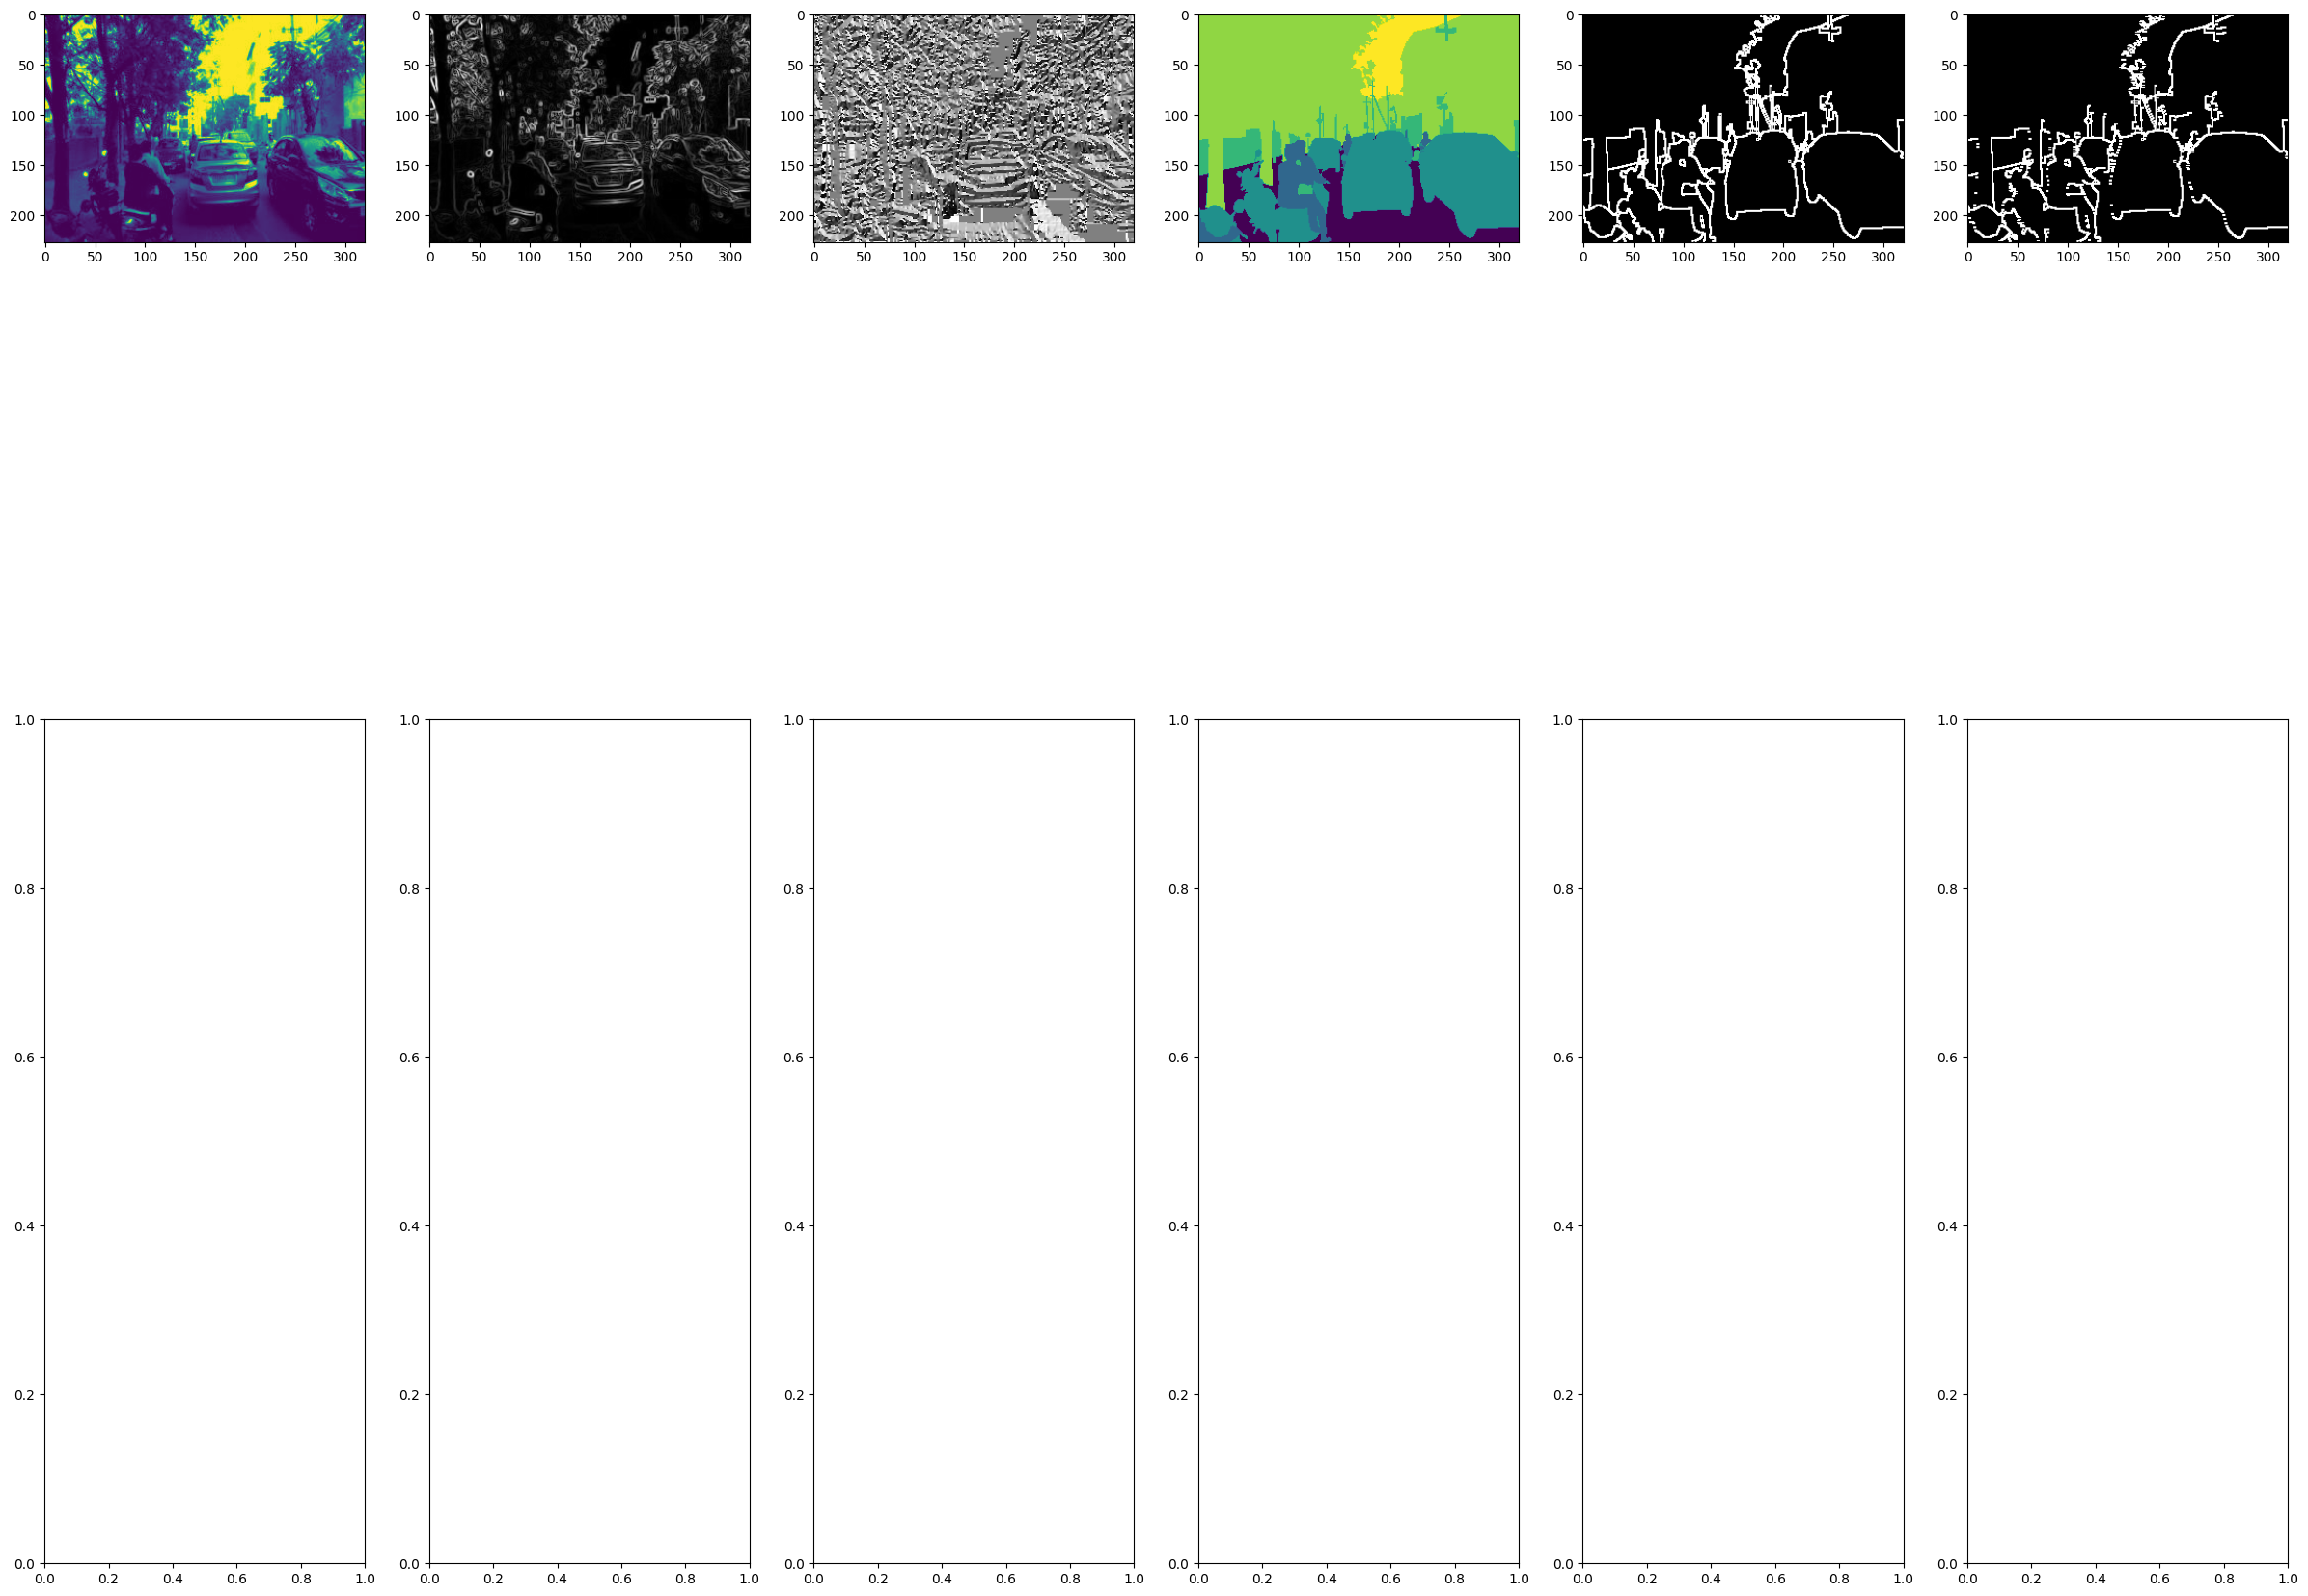

In [ ]:
from PIL import Image
import numpy as np
import imgaug.augmenters as iaa

#Sample of image, image'smagnitude, image's oreintation, label, label's magnitude, label's oreintation

fig,ax=plt.subplots(2,6,figsize=(30,25))

aug_ed=iaa.EdgeDetect(alpha=1)
img_path=train_data['image'][3]
mask_path=train_data['mask'][3]
img=cv2.imread(img_path)
img_mask=cv2.imread(mask_path)
img_mask[img_mask==255]=0
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.0
gray_mask=img_mask[:,:,1]

#Gradient for image
gX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
gY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

#gradient for mask
gX_mask = cv2.Sobel(gray_mask, cv2.CV_64F, 1, 0)
gY_mask = cv2.Sobel(gray_mask, cv2.CV_64F, 0, 1)

#Equal Weightage for both the gradients
combined = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

# compute the gradient magnitude and orientation
#for image
magnitude = np.sqrt((gX ** 2) + (gY ** 2))
orientation = np.arctan2(gY, gX) * (180 / np.pi) /180
#for labels
magnitude_mask = np.sqrt((gX_mask ** 2) + (gY_mask ** 2))
orientation_mask = np.ceil(abs(np.arctan2(gY_mask, gX_mask) * (180 / np.pi) /180))
#If the magnitude of the labels is greater than 0 then the value is set to 1
#This is because magnitude shows the strength of the change in the image. Incase of labels there will be change only when the pixels change to other class.
#Therby the value increases only on the edges between the class and the rest part will be 0. Therfore setting 1 to all values that are not 0
magnitude_mask[magnitude_mask>0] = 1



ax[0][0].imshow(gray)
ax[0][1].imshow(magnitude, cmap="gray")
ax[0][2].imshow(orientation, cmap="gray")
ax[0][3].imshow(gray_mask)
ax[0][4].imshow(magnitude_mask, cmap='gray')
ax[0][5].imshow(orientation_mask, cmap='gray')

##2. Dataset Preperation and Augmentation##

In [ ]:
#Creating Directory to save the prepared dataset to be able to load conviniently from the location when loading from DataLoader
import os
os.mkdir("/content/processed_data")
os.mkdir("/content/processed_data/train_data")
os.mkdir("/content/processed_data/train_label_data")
os.mkdir("/content/processed_data/train_label_edge_data")
os.mkdir("/content/processed_data/test_data")
os.mkdir("/content/processed_data/test_label_data")
os.mkdir("/content/processed_data/test_label_edge_data")

###Preperation for train dataset###

In [ ]:
import cv2
import matplotlib

#Setting the height and width
height=224
width=320
n_classes=7

def prepare_image_data(path,data_kind):
    """Function to prepare the image dataset and save it to the location"""
    name = path.split('/')[-1]
    data_kind = data_kind
    src=path
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img = np.float32(img)
    cv2.imwrite("/content/processed_data/{0}/{1}".format(data_kind,name),img)

def prepare_label_data(path,data_kind):
    """Function to prepare the image label dataset and save it to the location"""
    name = path.split('/')[-1]
    data_kind = data_kind
    label = np.zeros((height, width, n_classes))
    src=path
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img1=img[:,:,0]
    for i in range(n_classes):
        label[:,:,i] = (img1==i).astype(int)
    cv2.imwrite("/content/processed_data/{0}/{1}".format(data_kind,name),np.argmax(label,axis=-1))

def prepare_edge_data(path,data_kind):
    """Function to prepare the magnitude of image lable dataset and save it to the location"""
    name = path.split('/')[-1]
    data_kind = data_kind
    label = np.zeros((height, width, n_classes))
    src=path
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img1=img[:,:,0]
    img1[img1==255]=0
    gray_mask=cv2.resize(img1,(320,224))
    gX_mask = cv2.Sobel(gray_mask, cv2.CV_64F, 1, 0)
    gY_mask = cv2.Sobel(gray_mask, cv2.CV_64F, 0, 1)
    magnitude_mask = np.sqrt((gX_mask ** 2) + (gY_mask ** 2))
    magnitude_mask[magnitude_mask>0] = 1
    cv2.imwrite("/content/processed_data/{0}/{1}".format(data_kind,name),magnitude_mask)


In [ ]:
#Creating list for storing the path of the datasets for training dataset
X_train=[]
y_train=[]
y_train_edge=[]

data_root = "/content/processed_data"

for i in range(len(train_data['image'])):
    prepare_image_data(train_data['image'][i],'train_data')
    X_train.append(os.path.join(os.path.join(data_root,'train_data'),train_data["image"][i].split('/')[-1]))

for i in range(len(train_data['mask'])):
    prepare_label_data(train_data['mask'][i],'train_label_data')
    y_train.append(os.path.join(os.path.join(data_root,'train_label_data'),train_data["mask"][i].split('/')[-1]))

for i in range(len(train_data['mask'])):
    prepare_edge_data(train_data['mask'][i],'train_label_edge_data')
    y_train_edge.append(os.path.join(os.path.join(data_root,'train_label_edge_data'),train_data["mask"][i].split('/')[-1]))


In [ ]:
#Converting it to pandas Dataframe
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
y_train_edge=pd.DataFrame(y_train_edge)

In [ ]:
#Image Data Generator
from keras.preprocessing.image import ImageDataGenerator

#Data Augmentation
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True,zoom_range=0.25,interpolation_order=0,dtype=np.float64,shear_range=0.2)
# prepare iterator
trainX_gen = datagen.flow_from_dataframe(X_train,seed=1234,batch_size=4,class_mode=None,x_col=0,color_mode='rgb',target_size=(height,width))
trainY_gen = datagen.flow_from_dataframe(y_train,seed=1234,batch_size=4,class_mode=None,x_col=0,color_mode='grayscale',target_size=(height,width))
trainY_gen_ed = datagen.flow_from_dataframe(y_train_edge,seed=1234,batch_size=4,class_mode=None,x_col=0,color_mode='grayscale',target_size=(height,width))

train_generator = zip(trainX_gen, zip(trainY_gen,trainY_gen_ed))

Found 1403 validated image filenames.
Found 1403 validated image filenames.
Found 1403 validated image filenames.
Found 204 validated image filenames.
Found 204 validated image filenames.
Found 204 validated image filenames.


###Preperation for validation dataset###

In [ ]:
X_val=[]
y_val=[]
y_val_edge=[]

for i in range(len(test_data['image'])):
    prepare_image_data(test_data['image'][i],'test_data')
    X_val.append(os.path.join(os.path.join(data_root,'test_data'),test_data["image"][i].split('/')[-1]))

for i in range(len(test_data['mask'])):
    prepare_label_data(test_data['mask'][i],'test_label_data')
    y_val.append(os.path.join(os.path.join(data_root,'test_label_data'),test_data["mask"][i].split('/')[-1]))

for i in range(len(test_data['mask'])):
    prepare_edge_data(test_data['mask'][i],'test_label_edge_data')
    y_val_edge.append(os.path.join(os.path.join(data_root,'test_label_edge_data'),test_data["mask"][i].split('/')[-1]))

In [ ]:
#Instead of using Image datagen we will be using the complete image, label. and label edge loaded in-memory.
X_val_test=[]
y_val_test=[]
y_val_edge_test=[]

def prepare_val_image_data(path):
    src=path
    img = plt.imread(src)
    img = np.float32(img)
    return img

def prepare_val_label_data(path):
    label = np.zeros((height, width, n_classes))
    src=path
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img1=img[:,:,0]
    for i in range(n_classes):
        label[:,:,i] = (img1==i).astype(int)
    return np.argmax(label,axis=-1).astype(np.float64)[:,:,np.newaxis]

def prepare_val_edge_data(path):
    src=path
    img = cv2.imread(src)
    return img[:,:,0].astype(np.float64)[:,:,np.newaxis]

for i in range(len(X_val[0])):
    X_val_test.append(prepare_val_image_data(X_val[0][i]))

for i in range(len(y_val[0])):
    y_val_test.append(prepare_val_label_data(y_val[0][i]))

for i in range(len(y_val_edge[0])):
    y_val_edge_test.append(prepare_val_edge_data(y_val_edge[0][i]))

X_val_test=np.array(X_val_test)
y_val_test=np.array(y_val_test)
y_val_edge_test=np.array(y_val_edge_test)

In [ ]:
print(X_val_test.shape)
print(y_val_test.shape)
print(y_val_edge_test.shape)

(204, 224, 320, 3)
(204, 224, 320, 1)
(204, 224, 320, 1)


##3. Setting Metrics##

Here we will be setting with miou- mean Intersection Over Union

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-j4wve8xv
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-j4wve8xv
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33791 sha256=35e1c306b53c4c3c55e8acb8a59873b7a554efd804b18ffef8590ac5c07f02da
  Stored in directory: /tmp/pip-ephem-wheel-cache-ggay9_w8/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation-models


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [ ]:
#Settting steps per epoch
steps_per_epoch=X_train.shape[0]//2
print(steps_per_epoch)
validation_steps=X_val.shape[0]//2
print(validation_steps)

701
102


In [ ]:
def IoU(y_val, y_pred):
    class_iou = []
    n_classes = 7

    y_predi = np.argmax(y_pred, axis=-1)
    y_truei = y_val[:,:,:,0]

    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c))
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : IoU( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

#Creating Architecture#

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8zfy8n73
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8zfy8n73
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33791 sha256=d3ed3f2c5fba5f2ff6434a9fa0a6f40c89b5731d6ad8b9946b9e9b099b3ebe11
  Stored in directory: /tmp/pip-ephem-wheel-cache-fayrwfxr/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation-models


In [ ]:
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [ ]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.

####Decoder Block####
The decoder block is a simple decoding Unet block that upsamples the input and concatenates with the skip connection outputs.

    Input: X --> X[0],X[1]
              X[0] contains the previous layer output.
              X[1] contains the connection output.


    Architecture:
        Upsampling2D(X[0])(mode="bilinear", size=(2,2))
        concatenate(upsample,X[1])
        Conv2D
        BatchNormalization
        Relu
        Conv2D
        BatchNormalization
        Relu

In [ ]:
#Setting the Decoder Block
class DecoderBlock(tf.keras.layers.Layer):
  def __init__(self,filters,stride=1,kernel_size=3,name='dec_block'):
    super().__init__(name=name)
    self.stride=stride
    self.filters=filters
    self.kernel_size=kernel_size

  def build(self,input_shape):
    self.upsampler=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.conv_1=Conv2D(filters=self.filters,kernel_size=self.kernel_size,strides=self.stride,padding='same',kernel_initializer="he_normal")
    self.bn_1=BatchNormalization()
    self.relu_1=Activation('relu')
    self.conv_2=Conv2D(filters=self.filters,kernel_size=self.kernel_size,strides=self.stride,padding='same',kernel_initializer="he_normal")
    self.bn_2=BatchNormalization()
    self.relu_2=Activation('relu')

  def call(self,X):
    prev_layer=X[0]
    connect_layer=X[1]
    upsample_out=self.upsampler(prev_layer)
    concat_out=concatenate([upsample_out,connect_layer])
    out_1=self.conv_1(concat_out)
    out_1=self.bn_1(out_1)
    out_1=self.relu_1(out_1)
    out_1=self.conv_2(out_1)
    out_1=self.bn_2(out_1)
    out_1=self.relu_2(out_1)
    return out_1

####U-Shape-Net Modules####
#####GCL Block#####
GCL Block acts as an attention block which help in predicting the image edges.

    Input: X --> X[0], X[1]
                  X[0] is the output shape flow
                  X[1] is the output from the regular decoder flow


    Architecture:
        concatenate(X[0],X[1])
        Conv2D(filters=1, kernel_size=1) #This is acts as attention layer for edge detection
        Sigmoid
        Elementwise multiplication(X[0],Conv2D(attention))
        Elementwise addition(elem_multi, X[0])
        Conv2D(filters=1, kernel_size=1)

#####Residual Block#####
This block is simple residual block that does residual connection.

    Input: X --> X
                  X is the output of previous layer

    Architecture:
        Conv2D(filters,kernel_size=1)
        BatchNormalization
        Relu
        Conv2D(filters*2,kernel_size=kernel_size)
        BatchNormalization
        Relu
        Conv2D(filters,kernel_size=1)
        BatchNormalization
        Relu

#####Upsampler Block#####
This block upsamples the shape output

    Input: X --> X
                  X is the output of previous layer

    Architecture:
        UpSampling2D(mode="bilinear",size=(2,2))
        Conv2D(filters,kernel_size=kernel_size)
        BatchNormalization
        Relu
        Conv2D(filters*2,kernel_size=kernel_size)
        BatchNormalization
        Relu
        Conv2D(filters,kernel_size=kernel_size)
        BatchNormalization
        Relu

In [ ]:
#Setting the GCL Block
class GclBlock(tf.keras.layers.Layer):
    def __init__(self,kernel=3,filters=1,stride=1,pool_size=None,name='gcl',padding='valid'):
      super().__init__(name=name)
      self.kernel=kernel
      self.filters=filters
      self.stride=stride
      self.pool_size=pool_size
      self.padding=padding
      if self.pool_size:
        self.padding='same'
      if self.stride>1:
        self.padding='valid'

    def build(self,input_shape):
      self.att_layer1=Conv2D(filters=1,kernel_size=1,kernel_initializer="he_normal")
      self.bn_1_layer=BatchNormalization()
      self.final_layer=Conv2D(filters=1,kernel_size=1,strides=self.stride,kernel_initializer="he_normal")
      self.relu_act=Activation('relu')
      self.bn_1_layer=BatchNormalization()
      self.activation_sig=Activation('sigmoid')
      self.elem_multiply=Multiply()
      self.elem_addition=Add()
      if self.pool_size:
        self.pool_layer=MaxPooling2D((self.pool_size,self.pool_size))
    def call(self,X):
      shape_flow,regular_flow=X[0],X[1]
      concat_out=concatenate([shape_flow,regular_flow],axis=-1)
      conv_out=self.att_layer1(concat_out)
      att_out=self.activation_sig(conv_out)
      multiply_out=self.elem_multiply([shape_flow,att_out])
      add_out=self.elem_addition([multiply_out,shape_flow])
      final_out=self.final_layer(add_out)
      if self.pool_size:
        final_out=self.pool_layer(final_out)
      return final_out

#Setting Residual Block
class ResBlock(tf.keras.layers.Layer):
    def __init__(self,kernel=3,filters=1,name='res_block'):
      super().__init__(name=name)
      self.kernel=kernel
      self.filters=filters
    def build(self,input_shape):
      self.conv1=Conv2D(filters=self.filters,kernel_size=1,padding='same')
      self.conv2=Conv2D(filters=self.filters*2,kernel_size=self.kernel,padding='same')
      self.conv3=Conv2D(filters=self.filters,kernel_size=1,padding='same')
      self.bn1=BatchNormalization()
      self.bn2=BatchNormalization()
      self.bn3=BatchNormalization()
      self.activation1=Activation('relu')
      self.activation2=Activation('relu')
      self.activation3=Activation('relu')
      self.elem_addition=Add()
    def call(self,X):
      conv1_out=self.conv1(X)
      bn1_out=self.bn1(conv1_out)
      act1_out=self.activation1(bn1_out)
      conv2_out=self.conv2(act1_out)
      bn2_out=self.bn2(conv2_out)
      act2_out=self.activation2(bn2_out)
      conv3_out=self.conv3(act2_out)
      bn3_out=self.bn3(conv3_out)
      add_out=self.elem_addition([bn3_out,X])
      final_out=self.activation3(add_out)
      return final_out

#Setting Upsampler Block
class UpsamplerBlock(tf.keras.layers.Layer):
  def __init__(self,filters,upsample_size,name="upsamp_block",kernel_size=3,strides=1):
    super().__init__(name=name)
    self.filters=filters
    self.kernel_size=kernel_size
    self.strides=strides
    self.upsample_size=upsample_size

  def build(self,input_shape):
    self.upsampler=UpSampling2D(size=(self.upsample_size,self.upsample_size),interpolation="bilinear")
    self.conv_out_1=Conv2D(filters=self.filters,kernel_size=self.kernel_size,strides=self.strides,padding='same',kernel_initializer="he_normal")
    self.batch_norm_1=BatchNormalization()
    self.act_1=Activation('relu')
    self.conv_out_2=Conv2D(filters=self.filters,kernel_size=self.kernel_size,strides=self.strides,padding='same',kernel_initializer="he_normal")
    self.batch_norm_2=BatchNormalization()
    self.act_2=Activation('relu')
    self.conv_out_3=Conv2D(filters=self.filters,kernel_size=1,strides=self.strides,padding='same',kernel_initializer="he_normal")

  def call(self,X):
    output=self.upsampler(X)
    output=self.conv_out_1(output)
    output=self.batch_norm_1(output)
    output=self.act_1(output)
    output=self.conv_out_2(output)
    output=self.batch_norm_2(output)
    output=self.act_2(output)
    output=self.conv_out_3(output)
    return output

###Training Plain U-net with ResNet-50 as encoder###

In [ ]:
import segmentation_models
model = segmentation_models.Unet(backbone_name='resnet50', encoder_weights='imagenet', encoder_freeze=False,input_shape=(224,320,3),classes=7,activation="softmax")
model.summary()

import segmentation_models as sm
optim=tf.keras.optimizers.Adam(0.001)

dice_loss=sm.losses.DiceLoss()
bin_ce=tf.keras.losses.BinaryCrossentropy()
categorical_ce=tf.keras.losses.SparseCategoricalCrossentropy()
biou=sm.metrics.IOUScore()
binary_loss=sm.losses.BinaryFocalLoss()
model.compile(optim,loss={"softmax":lambda y_true,y_pred: dice_loss(y_true,y_pred)+categorical_ce(y_true,y_pred)},
                   metrics={"softmax":miou})

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model_canet_t3.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard('TBlog_canet_t3',histogram_freq=1),
#    tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01,patience=3,verbose=1,mode='min'),
		tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=4,verbose=1,mode='min',min_lr=0.00001,min_delta=0.0001)
]
history_resnet_1 = model.fit(train_generator, epochs=40,steps_per_epoch=steps_per_epoch,validation_data=(X_val_test,y_val_test),callbacks=callbacks)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 320, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 230, 326, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

In [ ]:
#Prediction on validation dataset
pred = []
for i in range(len(X_val_test)):
  pred.append(model.predict(X_val_test[i][np.newaxis,:,:,:])[0])
pred1 = np.array(pred)

1/1 [==============================] - 0s 35ms/step


In [ ]:
#Claculating class wise mIoU for the validation dataset
def class_wise_IoU(y_val, y_pred):
    class_iou = []
    n_classes = 7

    y_predi = np.argmax(y_pred, axis=-1)
    y_truei = y_val[:,:,:,0]

    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c))
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    return class_iou
cwiou = class_wise_IoU(y_val_test,pred1)
print("overall IoU score for resnet50 with Unet: {}".format(IoU(y_val_test,pred1)))
print("class wise IoU score for resnet50 with Unet")
for i in range(len(cwiou)):
    print("class {0} IoU score: {1}".format(i,cwiou[i]))

overall IoU score for resnet50 with Unet: 0.6786559541382934
class wise IoU score for resnet50 with Unet
class 0 IoU score: 0.9353041127077119
class 1 IoU score: 0.38891453537497683
class 2 IoU score: 0.4604198143751349
class 3 IoU score: 0.7635513712545677
class 4 IoU score: 0.4819599950720166
class 5 IoU score: 0.7625738189882885
class 6 IoU score: 0.9578680311953571


###Training Modified U-Shape-Net Model with resnet-50 encoder###

In [ ]:
resnet=tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(224,320,3))
resnet.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
def encoder(inputs):
    skip_connections = []

    model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]
    for layer in model.layers:
        layer.trainable=False
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("conv5_block3_out").output
    return output, skip_connections

keras.backend.clear_session()
X_inp = Input(shape=(224,320,3))
# Encoder
c_5_5,conv_blocks = encoder(X_inp)
c_1_1,c_2_2,c_3_3,c_4_4=conv_blocks[0],conv_blocks[1],conv_blocks[2],conv_blocks[3]

# Decoder
dec_1_out=DecoderBlock(filters=256,name="decoder_1")((c_5_5,c_4_4))
dec_2_out=DecoderBlock(filters=128,name="decoder_2")((dec_1_out,c_3_3))
dec_3_out=DecoderBlock(filters=64,name="decoder_3")((dec_2_out,c_2_2))
dec_4_out=DecoderBlock(filters=32,name="decoder_4")((dec_3_out,c_1_1))
dec_5_upsamp=UpSampling2D(size=(2,2),interpolation='bilinear')(dec_4_out)
dec_5_conv1=Conv2D(filters=16,name="decoder_5_conv1",strides=1,kernel_size=3,padding="same")(dec_5_upsamp)
dec_5_bn1=BatchNormalization()(dec_5_conv1)
dec_5_act1=Activation("relu")(dec_5_bn1)
dec_5_conv2=Conv2D(filters=16,name="decoder_6_conv2",strides=1,kernel_size=3,padding="same")(dec_5_act1)
dec_5_bn2=BatchNormalization()(dec_5_conv2)
dec_5_act2=Activation("relu")(dec_5_bn2)

#Shape
conv_shape_out_1=Conv2D(filters=128,kernel_size=3,strides=1,padding="same")(dec_2_out)
upsample_out_1=UpsamplerBlock(filters=128,upsample_size=2,name="upsampler_1")(conv_shape_out_1)
res_out_1=ResBlock(filters=128,name="res_1")(upsample_out_1)
gcl_out_1=GclBlock(name="gcl_1")([res_out_1,dec_3_out])
upsample_out_2=UpsamplerBlock(filters=1,upsample_size=2,name="upsampler_2")(gcl_out_1)
res_out_2=ResBlock(filters=1,name="res_2")(upsample_out_2)
gcl_out_2=GclBlock(name="gcl_2")([res_out_2,dec_4_out])
upsample_out_3=UpsamplerBlock(filters=1,upsample_size=2,name="upsampler_3")(gcl_out_2)
res_out_3=ResBlock(filters=1,name="res_3")(upsample_out_3)
gcl_out_3=GclBlock(name='gcl_3')([res_out_3,dec_5_act2])
conv_shape_out_2=Conv2D(filters=1,kernel_size=3,strides=1,padding='same')(gcl_out_3)
sigmoid_out=Activation("sigmoid",name="sigmoid_out")(conv_shape_out_2)

#Final concatenation layers
concat_final_out=concatenate([sigmoid_out,dec_5_act2])
final_conv=Conv2D(filters=7,strides=1,kernel_size=3,padding="same")(concat_final_out)
softmax_out=Activation('softmax',name="softmax_out")(final_conv)

model_resnet=Model(inputs=X_inp,outputs=[softmax_out,sigmoid_out])

for layer in model_resnet.layers:
  layer.trainable=True
model_resnet.summary()

#Optimizer is Adam with lr 0.001
import segmentation_models as sm
optim=tf.keras.optimizers.Adam(0.001)

#For the final softmax, loss will be diceloss + categorical cross entropy
#For the Edge sigmoid, loss will be diceloss + binary cross entropy
#For the final softmax. metrics will be miou
#For the edge sigmoid. metrics will be biou(simple IoU score)

dice_loss=sm.losses.DiceLoss()
bin_ce=tf.keras.losses.BinaryCrossentropy()
categorical_ce=tf.keras.losses.SparseCategoricalCrossentropy()
biou=sm.metrics.IOUScore()
model_resnet.compile(optim,loss={"softmax_out":lambda y_true,y_pred: dice_loss(y_true,y_pred)+categorical_ce(y_true,y_pred),
                               "sigmoid_out":lambda y_true,y_pred: dice_loss(y_true,y_pred)+bin_ce(y_true,y_pred)},
                   metrics={"softmax_out":miou,"sigmoid_out":biou})

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model_canet_t3.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard('TBlog_canet_t3',histogram_freq=1),
		tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=4,verbose=1,mode='min',min_lr=0.00001,min_delta=0.0001)
]
history_resnet_1 = model_resnet.fit(train_generator, epochs=40,steps_per_epoch=steps_per_epoch,validation_data=(X_val_test,(y_val_test,y_val_edge_test)),callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#Prediction on the validation dataset
pred = []
for i in range(len(X_val_test)):
  pred.append(model_resnet.predict(X_val_test[i][np.newaxis,:,:,:])[0])
pred1 = np.array(pred)
pred1 = pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])

1/1 [==============================] - 0s 28ms/step


In [ ]:
#Class wise IoU score on validation dataset
def class_wise_IoU(y_val, y_pred):
    class_iou = []
    n_classes = 7

    y_predi = np.argmax(y_pred, axis=-1)
    y_truei = y_val[:,:,:,0]

    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c))
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    return class_iou
cwiou = class_wise_IoU(y_val_test,pred1)
print("overall IoU score for resnet50: {}".format(IoU(y_val_test,pred1)))
print("class wise IoU score for resnet50")
for i in range(len(cwiou)):
    print("class {0} IoU score: {1}".format(i,cwiou[i]))

overall IoU score for resnet50: 0.6818828536827107
class wise IoU score for resnet50
class 0 IoU score: 0.9381753223486402
class 1 IoU score: 0.38896461514365177
class 2 IoU score: 0.4714086558403688
class 3 IoU score: 0.7658375203379562
class 4 IoU score: 0.48149132116997995
class 5 IoU score: 0.767823852885584
class 6 IoU score: 0.9594786880527938


1/1 [==============================] - 0s 37ms/step


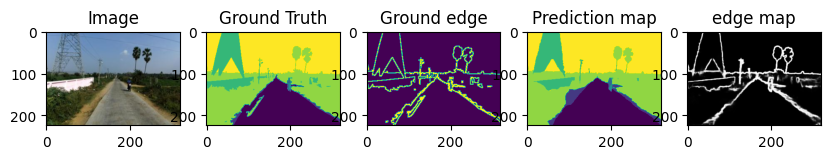

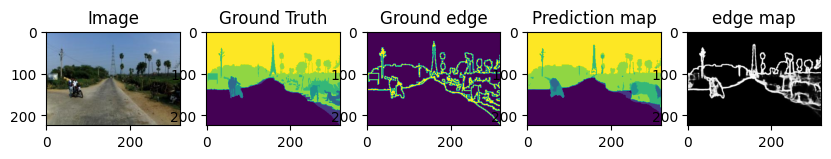

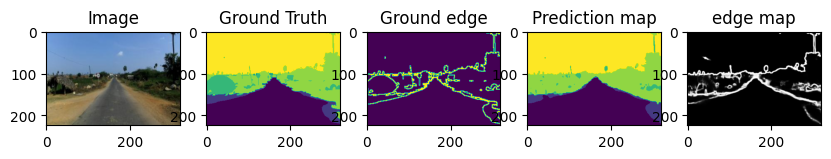

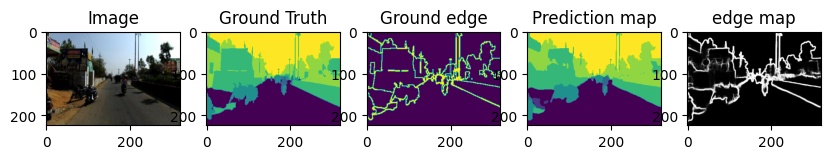

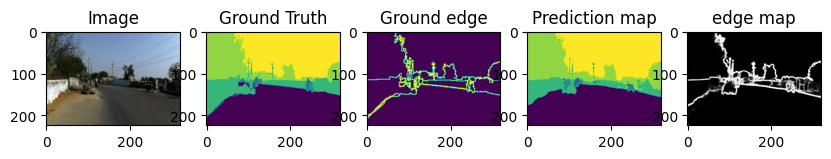

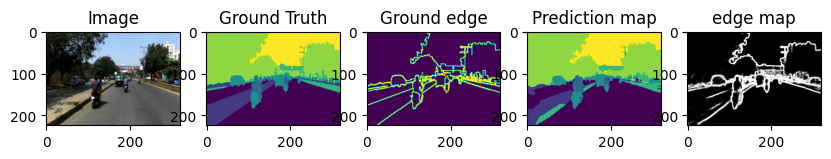

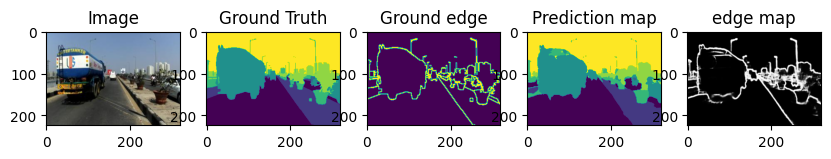

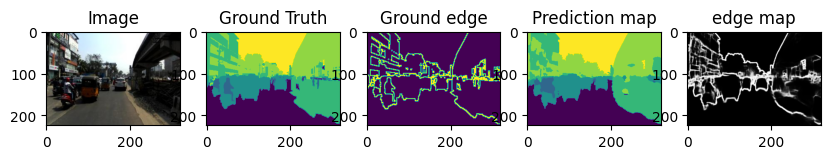

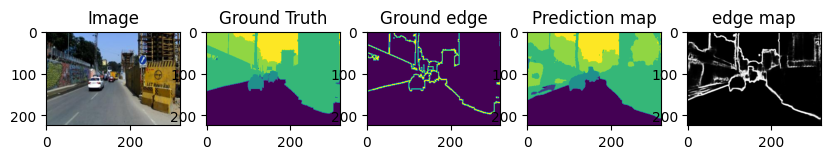

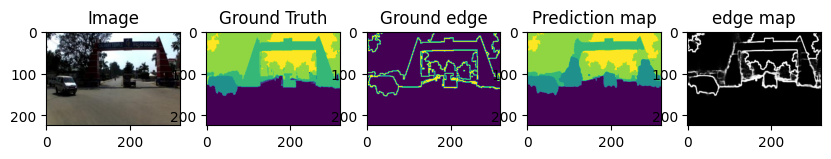

In [ ]:
#Inference on some of the validation dataset
for i in range(10):
  X_val_samp=X_val_test[i]
  y_pred_samp,y_pred_edge_samp=model_resnet.predict(X_val_samp[np.newaxis,:,:,:])
  plt.figure(figsize=(10,15))
  plt.subplot(151)
  plt.imshow(X_val_samp/255.0)
  plt.title('Image')
  plt.subplot(152)
  plt.imshow(y_val_test[i])
  plt.title('Ground Truth')
  plt.subplot(153)
  plt.imshow(y_val_edge_test[i])
  plt.title("Ground edge")
  plt.subplot(154)
  plt.imshow(np.argmax(y_pred_samp[0],axis=-1))
  plt.title('Prediction map')
  plt.subplot(155)
  plt.imshow(y_pred_edge_samp[0],cmap='gray')
  plt.title('edge map')

1/1 [==============================] - 0s 33ms/step


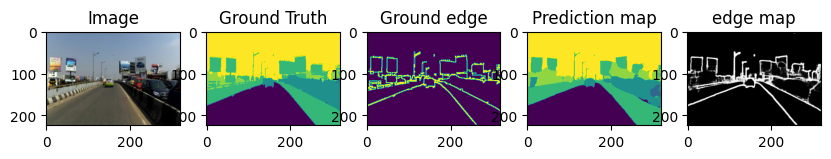

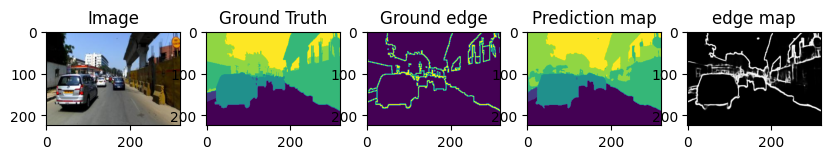

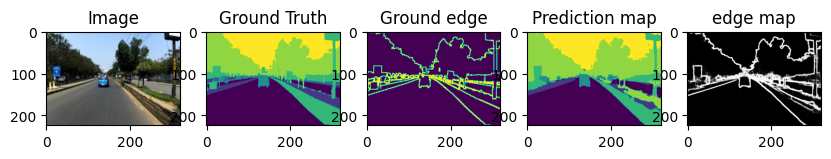

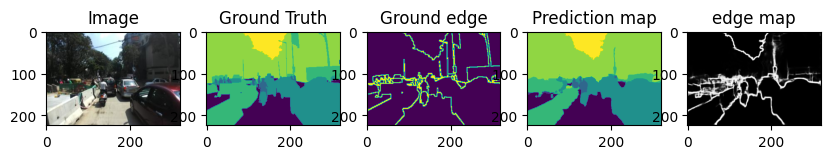

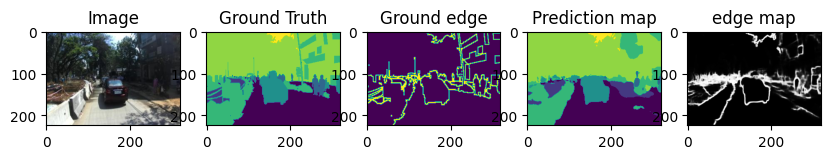

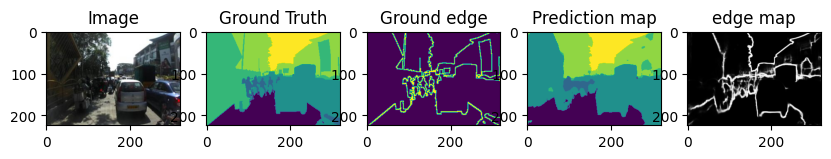

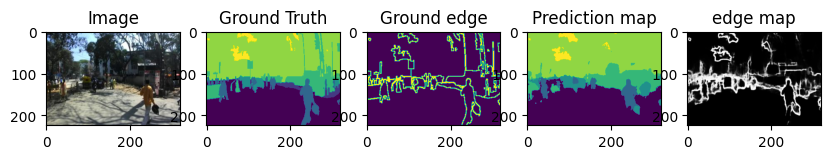

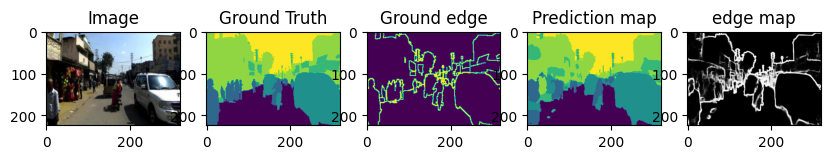

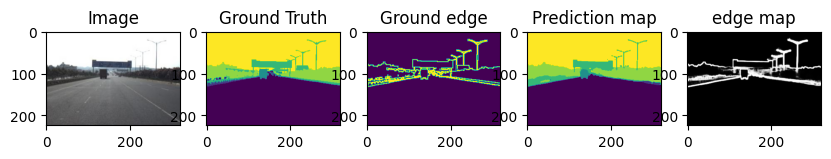

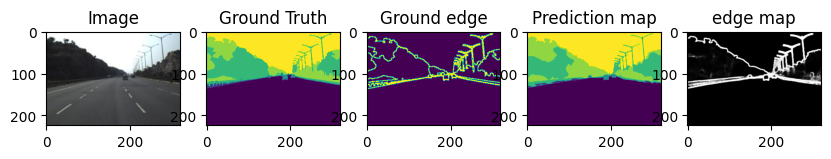

In [ ]:
for i in range(10,20):
    #original image
    #predicted segmentation map
  X_val_samp=X_val_test[i]
  y_pred_samp,y_pred_edge_samp=model_resnet.predict(X_val_samp[np.newaxis,:,:,:])
  plt.figure(figsize=(10,15))
  plt.subplot(151)
  plt.imshow(X_val_samp/255.0)
  plt.title('Image')
  plt.subplot(152)
  plt.imshow(y_val_test[i])
  plt.title('Ground Truth')
  plt.subplot(153)
  plt.imshow(y_val_edge_test[i])
  plt.title("Ground edge")
  plt.subplot(154)
  plt.imshow(np.argmax(y_pred_samp[0],axis=-1))
  plt.title('Prediction map')
  plt.subplot(155)
  plt.imshow(y_pred_edge_samp[0],cmap='gray')
  plt.title('edge map')

###Training modified U-shape-net with efficientNet-b5###

In [ ]:
def encoder(inputs):
    skip_connections = []

    model = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation"]
    for layer in model.layers:
        layer.trainable=False
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("top_activation").output
    return output, skip_connections

keras.backend.clear_session()
X_inp = Input(shape=(224,320,3))
# Encoder
c_5_5,conv_blocks = encoder(X_inp)
c_1_1,c_2_2,c_3_3,c_4_4=conv_blocks[0],conv_blocks[1],conv_blocks[2],conv_blocks[3]
# Decoder
dec_1_out=DecoderBlock(filters=256,name="decoder_1")((c_5_5,c_4_4))
dec_2_out=DecoderBlock(filters=128,name="decoder_2")((dec_1_out,c_3_3))
dec_3_out=DecoderBlock(filters=64,name="decoder_3")((dec_2_out,c_2_2))
dec_4_out=DecoderBlock(filters=32,name="decoder_4")((dec_3_out,c_1_1))
dec_5_upsamp=UpSampling2D(size=(2,2),interpolation='bilinear')(dec_4_out)
dec_5_conv1=Conv2D(filters=16,name="decoder_5_conv1",strides=1,kernel_size=3,padding="same")(dec_5_upsamp)
dec_5_bn1=BatchNormalization()(dec_5_conv1)
dec_5_act1=Activation("relu")(dec_5_bn1)
dec_5_conv2=Conv2D(filters=16,name="decoder_6_conv2",strides=1,kernel_size=3,padding="same")(dec_5_act1)
dec_5_bn2=BatchNormalization()(dec_5_conv2)
dec_5_act2=Activation("relu")(dec_5_bn2)

#Shape
conv_shape_out_1=Conv2D(filters=128,kernel_size=3,strides=1,padding="same")(dec_2_out)
upsample_out_1=UpsamplerBlock(filters=128,upsample_size=2,name="upsampler_1")(conv_shape_out_1)
res_out_1=ResBlock(filters=128,name="res_1")(upsample_out_1)
gcl_out_1=GclBlock(name="gcl_1")([res_out_1,dec_3_out])
upsample_out_2=UpsamplerBlock(filters=1,upsample_size=2,name="upsampler_2")(gcl_out_1)
res_out_2=ResBlock(filters=1,name="res_2")(upsample_out_2)
gcl_out_2=GclBlock(name="gcl_2")([res_out_2,dec_4_out])
upsample_out_3=UpsamplerBlock(filters=1,upsample_size=2,name="upsampler_3")(gcl_out_2)
res_out_3=ResBlock(filters=1,name="res_3")(upsample_out_3)
gcl_out_3=GclBlock(name='gcl_3')([res_out_3,dec_5_act2])
conv_shape_out_2=Conv2D(filters=1,kernel_size=3,strides=1,padding='same')(gcl_out_3)
sigmoid_out=Activation("sigmoid",name="sigmoid_out")(conv_shape_out_2)


#Final concatenation layers
concat_final_out=concatenate([sigmoid_out,dec_5_act2])
final_conv=Conv2D(filters=7,strides=1,kernel_size=3,padding="same")(concat_final_out)
softmax_out=Activation('softmax',name="softmax_out")(final_conv)

model_effnet=Model(inputs=X_inp,outputs=[softmax_out,sigmoid_out])
model_effnet.summary()

for layer in model_effnet.layers:
  layer.trainable=True
import segmentation_models as sm
optim=tf.keras.optimizers.Adam(0.001)

dice_loss=sm.losses.DiceLoss()
bin_ce=tf.keras.losses.BinaryCrossentropy()
categorical_ce=tf.keras.losses.SparseCategoricalCrossentropy()
biou=sm.metrics.IOUScore()
binary_loss=sm.losses.BinaryFocalLoss()
model_effnet.compile(optim,loss={"softmax_out":lambda y_true,y_pred: dice_loss(y_true,y_pred)+categorical_ce(y_true,y_pred),
                               "sigmoid_out":lambda y_true,y_pred: dice_loss(y_true,y_pred)+bin_ce(y_true,y_pred)},
                   metrics={"softmax_out":miou,"sigmoid_out":biou})

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model_canet_t4.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard('TBlog_canet_t4',histogram_freq=1),
		tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1,mode='min',min_lr=0.000001,min_delta=0.0001)
]
history_effnet_1 = model_effnet.fit(train_generator, epochs=40,steps_per_epoch=steps_per_epoch,validation_data=(X_val_test,(y_val_test,y_val_edge_test)),callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 320, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 320, 3)  0           ['normalization[0][0]']      

Epoch 1/40
701/701 [==============================] - 262s 196ms/step - loss: 2.3278 - softmax_out_loss: 1.3410 - sigmoid_out_loss: 0.9867 - softmax_out_miou: 0.4211 - sigmoid_out_iou_score: 0.1759 - val_loss: 2.2394 - val_softmax_out_loss: 1.3202 - val_sigmoid_out_loss: 0.9192 - val_softmax_out_miou: 0.4580 - val_sigmoid_out_iou_score: 0.2203 - lr: 0.0010
Epoch 2/40
701/701 [==============================] - 131s 187ms/step - loss: 2.0788 - softmax_out_loss: 1.2302 - sigmoid_out_loss: 0.8485 - softmax_out_miou: 0.4697 - sigmoid_out_iou_score: 0.2566 - val_loss: 2.0828 - val_softmax_out_loss: 1.2606 - val_sigmoid_out_loss: 0.8223 - val_softmax_out_miou: 0.4725 - val_sigmoid_out_iou_score: 0.2859 - lr: 0.0010
Epoch 3/40
701/701 [==============================] - 131s 187ms/step - loss: 1.9784 - softmax_out_loss: 1.1853 - sigmoid_out_loss: 0.7931 - softmax_out_miou: 0.4928 - sigmoid_out_iou_score: 0.2920 - val_loss: 1.9950 - val_softmax_out_loss: 1.1526 - val_sigmoid_out_loss: 0.8424 - v

In [ ]:
pred = []
for i in range(len(X_val_test)):
  pred.append(model_effnet.predict(X_val_test[i][np.newaxis,:,:,:])[0])
pred1 = np.array(pred)
pred1 = pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])


1/1 [==============================] - 0s 41ms/step


In [ ]:

def class_wise_IoU(y_val, y_pred):
    class_iou = []
    n_classes = 7

    y_predi = np.argmax(y_pred, axis=-1)
    y_truei = y_val[:,:,:,0]

    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c))
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    return class_iou
cwiou = class_wise_IoU(y_val_test,pred1)
print("overall IoU score for efficientnetb5: {}".format(IoU(y_val_test,pred1)))
print("class wise IoU score for efficientnetb5")
for i in range(len(cwiou)):
    print("class {0} IoU score: {1}".format(i,cwiou[i]))

overall IoU score for efficientnetb5: 0.6945720384168055
class wise IoU score for efficientnetb5
class 0 IoU score: 0.9454070583840454
class 1 IoU score: 0.4186246108658751
class 2 IoU score: 0.48195468476291037
class 3 IoU score: 0.7801266516951506
class 4 IoU score: 0.5065766878338582
class 5 IoU score: 0.7716345542548593
class 6 IoU score: 0.9576800211209384


1/1 [==============================] - 0s 44ms/step


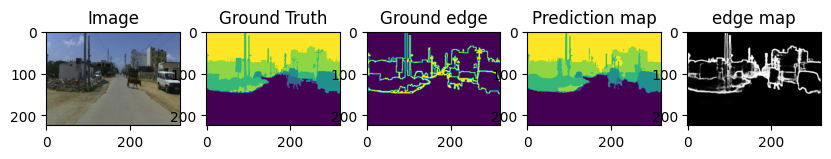

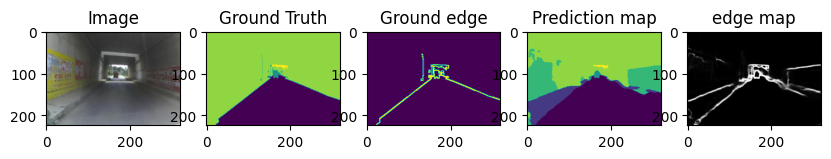

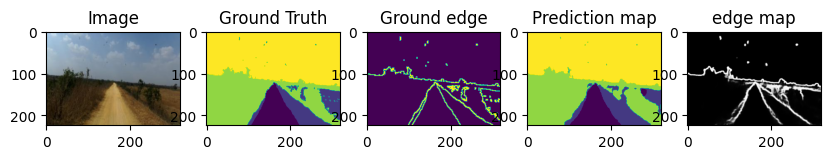

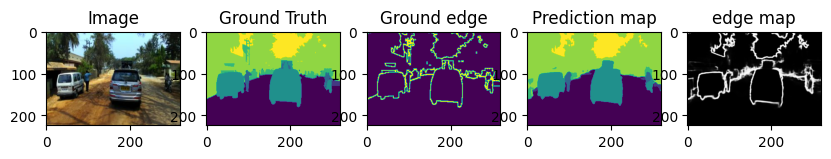

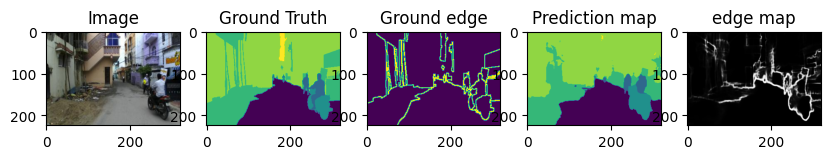

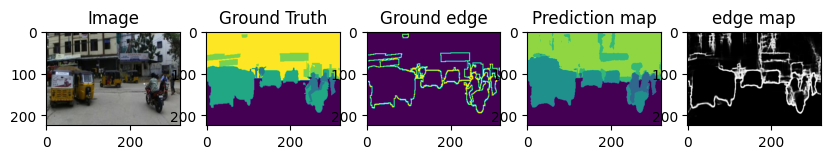

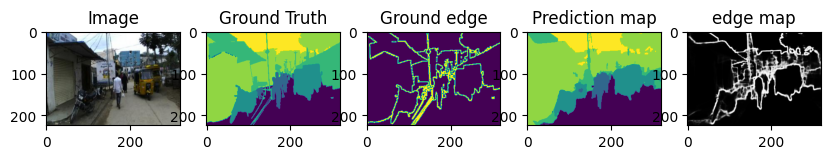

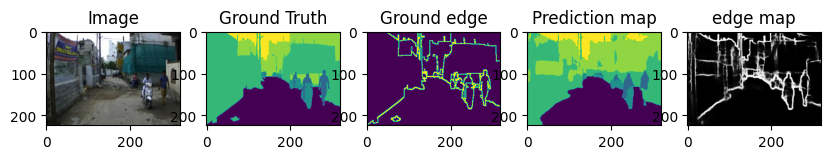

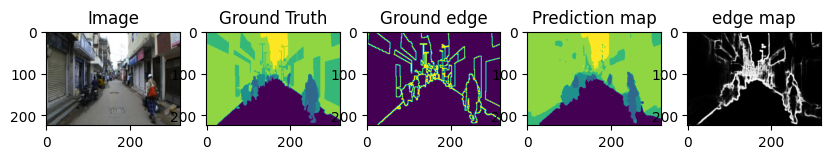

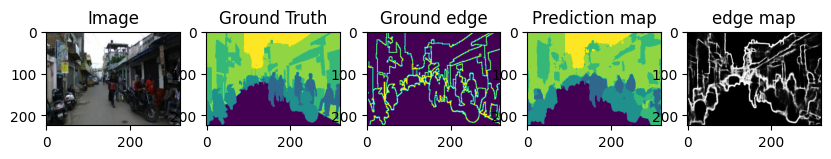

In [ ]:
for i in range(10):
  X_val_samp=X_val_test[i]
  y_pred_samp,y_pred_edge_samp=model_effnet.predict(X_val_samp[np.newaxis,:,:,:])
  plt.figure(figsize=(10,15))
  plt.subplot(151)
  plt.imshow(X_val_samp/255.0)
  plt.title('Image')
  plt.subplot(152)
  plt.imshow(y_val_test[i])
  plt.title('Ground Truth')
  plt.subplot(153)
  plt.imshow(y_val_edge_test[i])
  plt.title("Ground edge")
  plt.subplot(154)
  plt.imshow(np.argmax(y_pred_samp[0],axis=-1))
  plt.title('Prediction map')
  plt.subplot(155)
  plt.imshow(y_pred_edge_samp[0],cmap='gray')
  plt.title('edge map')

1/1 [==============================] - 0s 52ms/step


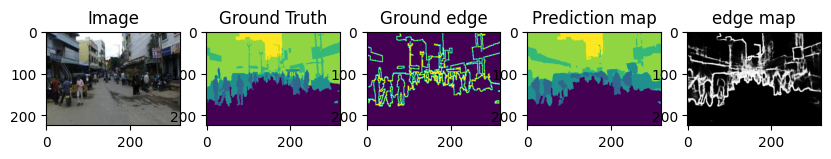

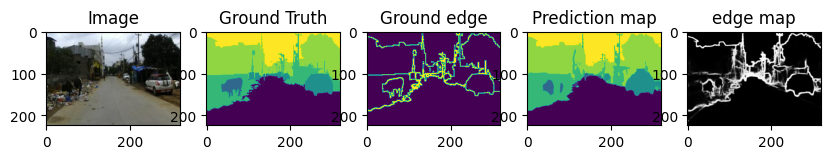

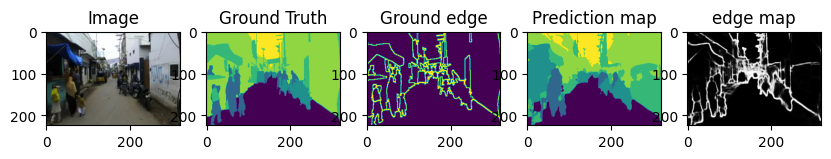

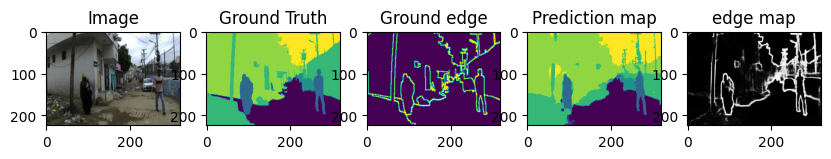

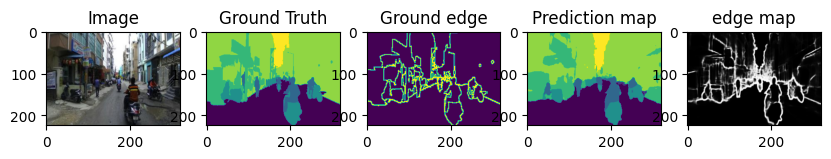

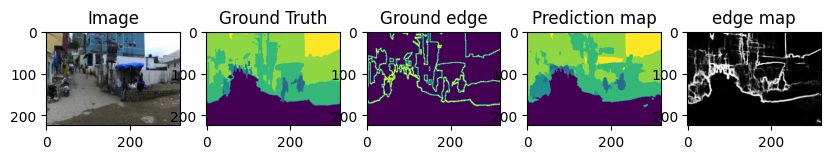

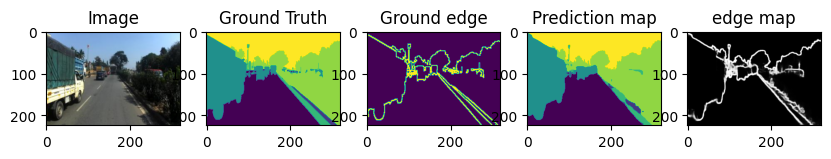

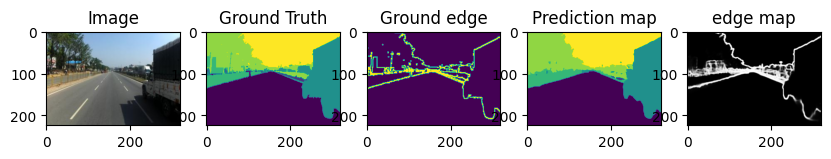

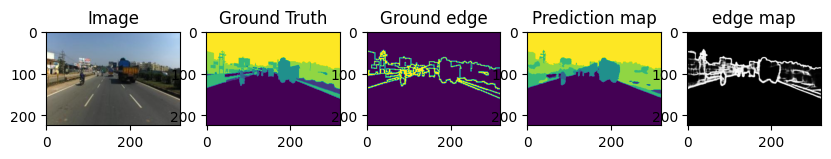

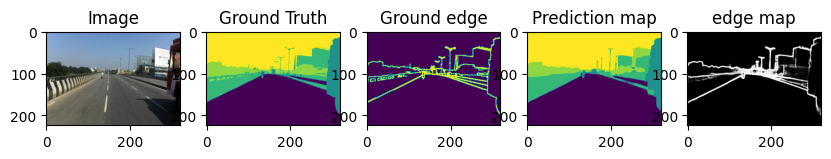

In [ ]:
for i in range(10,20):
  X_val_samp=X_val_test[i]
  y_pred_samp,y_pred_edge_samp=model_effnet.predict(X_val_samp[np.newaxis,:,:,:])
  plt.figure(figsize=(10,15))
  plt.subplot(151)
  plt.imshow(X_val_samp/255.0)
  plt.title('Image')
  plt.subplot(152)
  plt.imshow(y_val_test[i])
  plt.title('Ground Truth')
  plt.subplot(153)
  plt.imshow(y_val_edge_test[i])
  plt.title("Ground edge")
  plt.subplot(154)
  plt.imshow(np.argmax(y_pred_samp[0],axis=-1))
  plt.title('Prediction map')
  plt.subplot(155)
  plt.imshow(y_pred_edge_samp[0],cmap='gray')
  plt.title('edge map')

###Training the modified U-shape-edge with efficientnet-b7 as encoder####

In [ ]:
#encoder efficientnet b7
def encoder(inputs):
    skip_connections = []

    model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation", "block6a_expand_activation"]
    for layer in model.layers:
        layer.trainable=False
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("top_activation").output
    return output, skip_connections

keras.backend.clear_session()
X_inp = Input(shape=(224,320,3))
# Encoder
c_5_5,conv_blocks = encoder(X_inp)
c_1_1,c_2_2,c_3_3,c_4_4=conv_blocks[0],conv_blocks[1],conv_blocks[2],conv_blocks[3]

# Decoder
dec_1_out=DecoderBlock(filters=256,name="decoder_1")((c_5_5,c_4_4))
dec_2_out=DecoderBlock(filters=128,name="decoder_2")((dec_1_out,c_3_3))
dec_3_out=DecoderBlock(filters=64,name="decoder_3")((dec_2_out,c_2_2))
dec_4_out=DecoderBlock(filters=32,name="decoder_4")((dec_3_out,c_1_1))
dec_5_upsamp=UpSampling2D(size=(2,2),interpolation='bilinear')(dec_4_out)
dec_5_conv1=Conv2D(filters=16,name="decoder_5_conv1",strides=1,kernel_size=3,padding="same")(dec_5_upsamp)
dec_5_bn1=BatchNormalization()(dec_5_conv1)
dec_5_act1=Activation("relu")(dec_5_bn1)
dec_5_conv2=Conv2D(filters=16,name="decoder_6_conv2",strides=1,kernel_size=3,padding="same")(dec_5_act1)
dec_5_bn2=BatchNormalization()(dec_5_conv2)
dec_5_act2=Activation("relu")(dec_5_bn2)

# Shape output
conv_shape_out_1=Conv2D(filters=128,kernel_size=3,strides=1,padding="same")(dec_2_out)
upsample_out_1=UpsamplerBlock(filters=128,upsample_size=2,name="upsampler_1")(conv_shape_out_1)
res_out_1=ResBlock(filters=128,name="res_1")(upsample_out_1)
gcl_out_1=GclBlock(name="gcl_1")([res_out_1,dec_3_out])
upsample_out_2=UpsamplerBlock(filters=1,upsample_size=2,name="upsampler_2")(gcl_out_1)
res_out_2=ResBlock(filters=1,name="res_2")(upsample_out_2)
gcl_out_2=GclBlock(name="gcl_2")([res_out_2,dec_4_out])
upsample_out_3=UpsamplerBlock(filters=1,upsample_size=2,name="upsampler_3")(gcl_out_2)
res_out_3=ResBlock(filters=1,name="res_3")(upsample_out_3)
gcl_out_3=GclBlock(name='gcl_3')([res_out_3,dec_5_act2])
conv_shape_out_2=Conv2D(filters=1,kernel_size=3,strides=1,padding='same')(gcl_out_3)
sigmoid_out=Activation("sigmoid",name="sigmoid_out")(conv_shape_out_2)

#Final concatenation layers
concat_final_out=concatenate([sigmoid_out,dec_5_act2])
final_conv=Conv2D(filters=7,strides=1,kernel_size=3,padding="same")(concat_final_out)
softmax_out=Activation('softmax',name="softmax_out")(final_conv)
model_effnet=Model(inputs=X_inp,outputs=[softmax_out,sigmoid_out])


for layer in model_effnet.layers:
  layer.trainable=True
model_effnet.summary()

import segmentation_models as sm
optim=tf.keras.optimizers.Adam(0.0001)


dice_loss=sm.losses.DiceLoss()
bin_ce=tf.keras.losses.BinaryCrossentropy()
categorical_ce=tf.keras.losses.SparseCategoricalCrossentropy()
biou=sm.metrics.IOUScore()
binary_loss=sm.losses.BinaryFocalLoss()
model_effnet.compile(optim,loss={"softmax_out":lambda y_true,y_pred: dice_loss(y_true,y_pred)+categorical_ce(y_true,y_pred),
                               "sigmoid_out":lambda y_true,y_pred: dice_loss(y_true,y_pred)+bin_ce(y_true,y_pred)},
                   metrics={"softmax_out":miou,"sigmoid_out":biou})

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model_canet_t3.h5', save_weights_only=True, save_best_only=True, mode='min'),
  	tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=4,verbose=1,mode='min',min_lr=0.000001,min_delta=0.0001)
]
history_effnet_1 = model_effnet.fit(train_generator, epochs=40,steps_per_epoch=steps_per_epoch,validation_data=(X_val_test,(y_val_test,y_val_edge_test)),callbacks=callbacks)

258076736/258076736 [==============================] - 11s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 320, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)  

In [ ]:
model_effnet.evaluate(X_val_test,(y_val_test,y_val_edge_test))

7/7 [==============================] - 3s 387ms/step - loss: 1.6654 - softmax_out_loss: 1.0419 - sigmoid_out_loss: 0.6235 - softmax_out_miou: 0.6925 - sigmoid_out_iou_score: 0.4140


[1.6654469966888428,
 1.0419034957885742,
 0.6235435009002686,
 0.692548930644989,
 0.41401857137680054]

In [ ]:
pred = []
for i in range(len(X_val_test)):
  pred.append(model_effnet.predict(X_val_test[i][np.newaxis,:,:,:])[0])

1/1 [==============================] - 0s 55ms/step


In [ ]:
np.array(pred).shape

(204, 1, 224, 320, 7)

In [ ]:
pred1 = np.array(pred)
pred1 = pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
def class_wise_IoU(y_val, y_pred):
    class_iou = []
    n_classes = 7

    y_predi = np.argmax(y_pred, axis=-1)
    y_truei = y_val[:,:,:,0]

    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c))
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    return class_iou
cwiou = class_wise_IoU(y_val_test,pred1)
print("overall IoU score for efficientnetb7: {}".format(IoU(y_val_test,pred1)))
print("class wise IoU score for efficientnetb7")
for i in range(len(cwiou)):
    print("class {0} IoU score: {1}".format(i,cwiou[i]))

overall IoU score for efficientnetb7: 0.7023407517347408
class wise IoU score for efficientnetb7
class 0 IoU score: 0.9467853254051937
class 1 IoU score: 0.4456095683581029
class 2 IoU score: 0.49022296713901164
class 3 IoU score: 0.7776175637393767
class 4 IoU score: 0.5180504797555725
class 5 IoU score: 0.7772527566946869
class 6 IoU score: 0.960846601051241


1/1 [==============================] - 0s 56ms/step


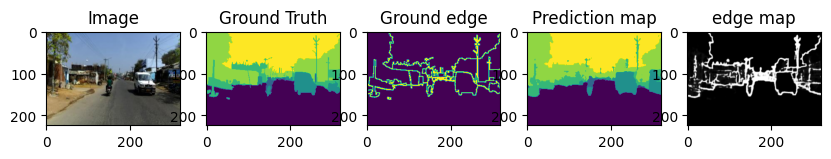

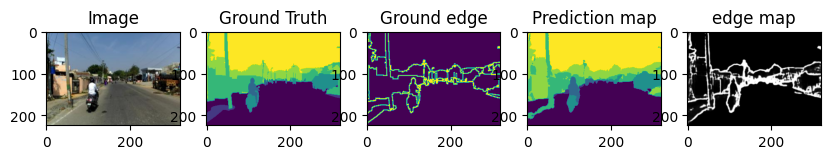

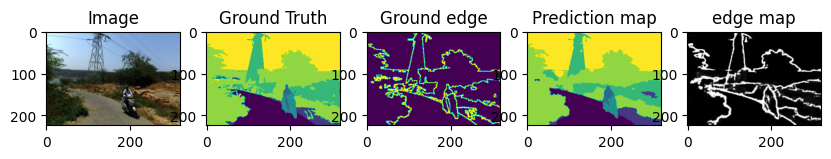

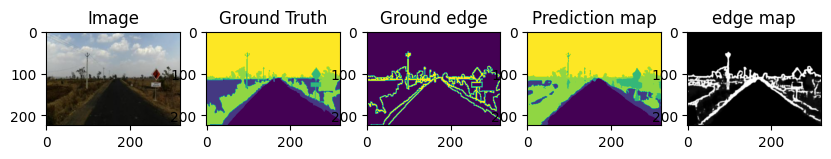

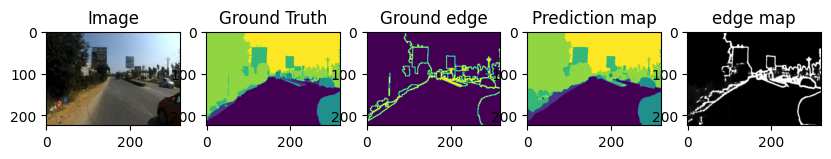

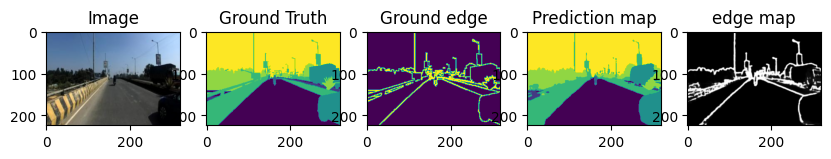

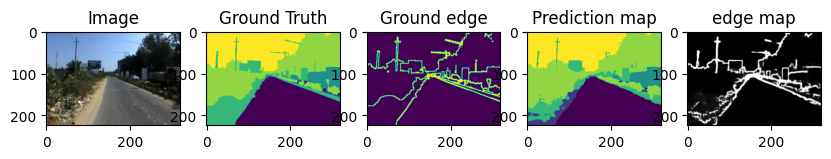

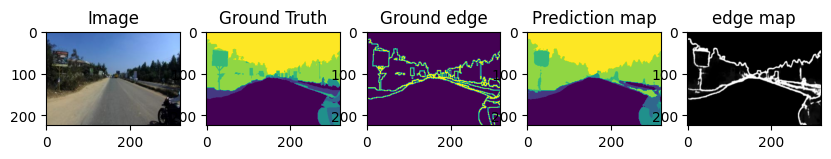

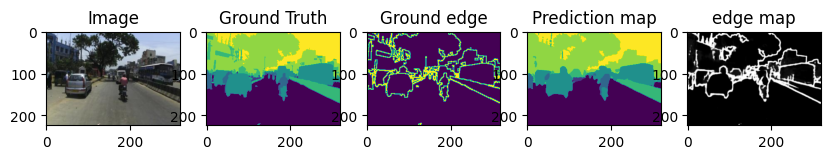

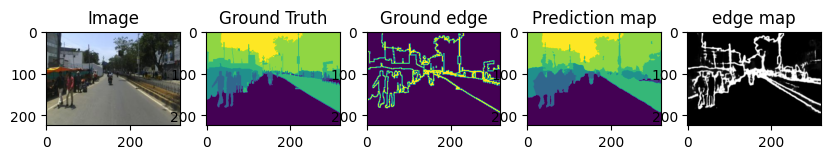

In [ ]:
for i in range(0,10):
  X_val_samp=X_val_test[i]
  y_pred_samp,y_pred_edge_samp=model_effnet.predict(X_val_samp[np.newaxis,:,:,:])
  plt.figure(figsize=(10,15))
  plt.subplot(151)
  plt.imshow(X_val_samp/255.0)
  plt.title('Image')
  plt.subplot(152)
  plt.imshow(y_val_test[i])
  plt.title('Ground Truth')
  plt.subplot(153)
  plt.imshow(y_val_edge_test[i])
  plt.title("Ground edge")
  plt.subplot(154)
  plt.imshow(np.argmax(y_pred_samp[0],axis=-1))
  plt.title('Prediction map')
  plt.subplot(155)
  plt.imshow(y_pred_edge_samp[0],cmap='gray')
  plt.title('edge map')

1/1 [==============================] - 0s 46ms/step


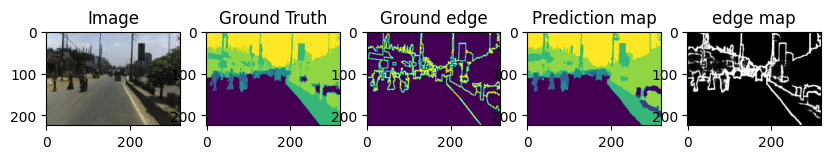

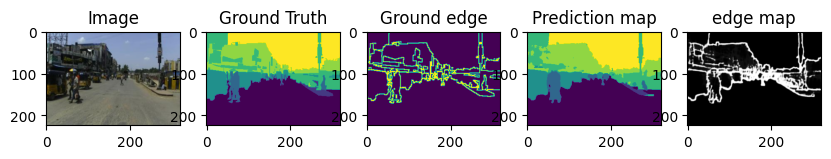

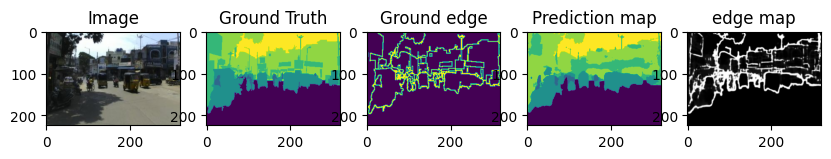

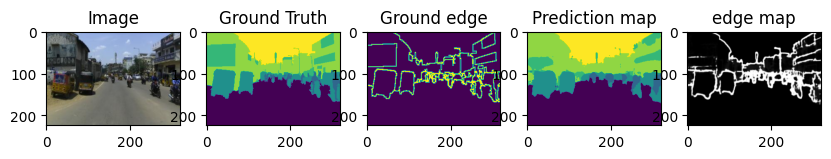

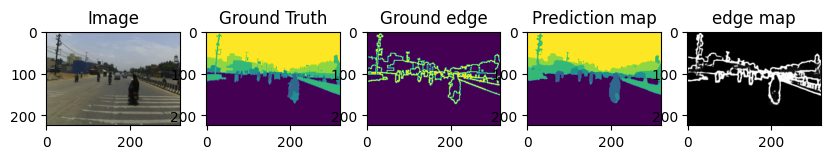

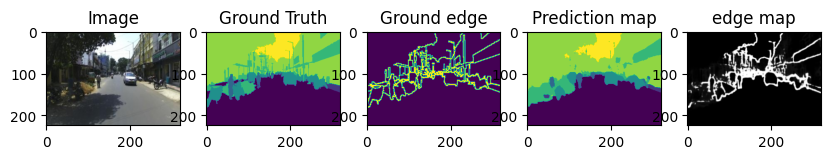

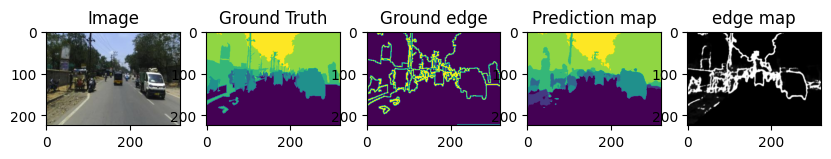

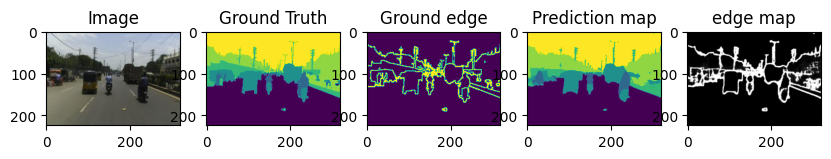

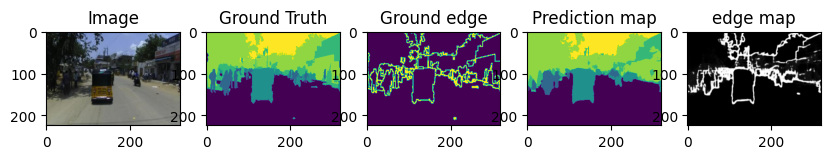

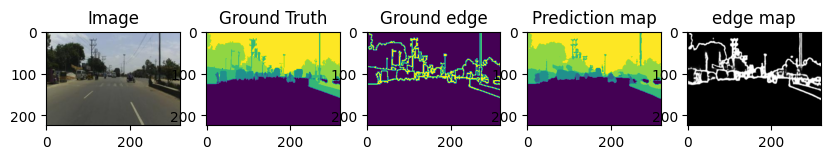

In [ ]:
for i in range(10,20):
  X_val_samp=X_val_test[i]
  y_pred_samp,y_pred_edge_samp=model_effnet.predict(X_val_samp[np.newaxis,:,:,:])
  plt.figure(figsize=(10,15))
  plt.subplot(151)
  plt.imshow(X_val_samp/255.0)
  plt.title('Image')
  plt.subplot(152)
  plt.imshow(y_val_test[i])
  plt.title('Ground Truth')
  plt.subplot(153)
  plt.imshow(y_val_edge_test[i])
  plt.title("Ground edge")
  plt.subplot(154)
  plt.imshow(np.argmax(y_pred_samp[0],axis=-1))
  plt.title('Prediction map')
  plt.subplot(155)
  plt.imshow(y_pred_edge_samp[0],cmap='gray')
  plt.title('edge map')